In [1]:
# This file estimates the transition matrix M, which shows the probability of a vote for party-i upon elimination being distributed to party-j.

In [2]:
# imports
import pandas as pd
import numpy as np
import os,sys

In [3]:
distribution_folders = os.listdir("dop_data")
distribution_files = []
for folder in distribution_folders:
    subfiles = os.listdir(f"dop_data/{folder}")
    for subfile in subfiles:
        distribution_files.append(f"dop_data/{folder}/{subfile}")

In [4]:
distribution_polling_place = pd.read_csv(distribution_files[0],header=1)
for file in distribution_files[1:]:
    distribution_polling_place = pd.concat([
        distribution_polling_place, pd.read_csv(file,header=1)
    ], ignore_index=True)

In [5]:
distribution_polling_place

,StateAb,DivisionId,DivisionNm,PPId,PPNm,CountNum,BallotPosition,CandidateId,Surname,GivenNm,PartyAb,PartyNm,SittingMemberFl,CalculationType,CalculationValue
0,ACT,318,Bean,0,ABSENT,0,1,36239,CONWAY,Sean,UAPP,United Australia Party,N,Preference Count,72.00
1,ACT,318,Bean,0,ABSENT,0,1,36239,CONWAY,Sean,UAPP,United Australia Party,N,Preference Percent,4.32
2,ACT,318,Bean,0,ABSENT,0,1,36239,CONWAY,Sean,UAPP,United Australia Party,N,Transfer Count,0.00
3,ACT,318,Bean,0,ABSENT,0,1,36239,CONWAY,Sean,UAPP,United Australia Party,N,Transfer Percent,0.00
4,ACT,318,Bean,0,ABSENT,0,2,37455,AMBARD,Aethan Benjamin Robert,ON,Pauline Hanson's One Nation,N,Preference Count,49.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2132811,WA,248,Tangney,108575,EAV COVID19 Tangney PPVC,7,8,37283,HOLROYD,Jacqueline Nicole,LDP,Liberal Democratic Party,N,Transfer Percent,0.00
2132812,WA,248,Tangney,108575,EAV COVID19 Tangney PPVC,7,9,36635,ABDUL RAZAK,Adam Shahabuddin,GRN,The Greens (WA) Inc,N,Preference Count,0.00
2132813,WA,248,Tangney,108575,EAV COVID19 Tangney PPVC,7,9,36635,ABDUL RAZAK,Adam Shahabuddin,GRN,The Greens (WA) Inc,N,Preference Percent,0.00
2132814,WA,248,Tangney,108575,EAV COVID19 Tangney PPVC,7,9,36635,ABDUL RAZAK,Adam Shahabuddin,GRN,The Greens (WA) Inc,N,Transfer Count,-239.00


In [6]:
# load in the data
# distribution_data = pd.read_csv("../data/historical_election_data/HouseDopByDivisionDownload-27966.csv",header=1)
# distribution_data.head()
distribution_data = distribution_polling_place

In [7]:
teal_candidates = pd.read_csv("teal.csv")
teal_candidates.head()


,DivisionNm,Surname,GivenNm
0,Boothby,DYER,Jo
1,Bradfield,BOELE,Nicolette
2,Calare,HOOK,Kate
3,Casey,FERRES MILES,Claire
4,Cowper,HEISE,Caz


In [9]:
parties_collected = ['UAPP', 'ON', 'ALP', 'IND', 'GRN', 'LP','NP','CLP','LNP','XEN', 'KAP']
party_mappers = {
    'UAPP':'UAP', 
    'ON':'ONP',
    'ALP':'ALP', 
    'IND':'IND', 
    'GRN':'GRN',
    'GVIC':'GRN',
    'LP':'LNP',
    'NP':'LNP',
    'CLP':'LNP',
    'LNP':'LNP',
    'XEN':'IND',
    'KAP':'IND',
}

# modeled_parties = ['UAP', 'ONP', 'ALP', 'GRN', 'LIB', 'NAT', 'CLP', 'LNP', 'IND', 'KAP', 'TEAL', 'OTH']
modeled_parties = ['UAP', 'ONP', 'ALP', 'GRN', 'LNP', 'IND', 'TEAL', 'OTH']

for idx,teal in teal_candidates.iterrows():
    givenNm = teal['GivenNm']
    surname = teal['Surname']
    division = teal['DivisionNm']
    distribution_data.loc[(distribution_data[['GivenNm','Surname','DivisionNm']]==[givenNm,surname,division]).all(axis=1),'PartyAb']="TEAL"

def partymap(row):
    party = row['PartyAb']
    if party in modeled_parties:
        party = party
    elif party in party_mappers.keys():
        party = party_mappers[party]
    elif pd.isna(party):
        if pd.isna(row['Surname']):
            party = "Informal"
        else:
            party = "IND"
    else:
        party = "OTH"
    row['PartyAb'] = party
    return row

distribution_data = distribution_data.apply(partymap,axis=1)

In [10]:
distribution_data["CountNumber"] = distribution_data["CountNum"]
# distribution_data["CountNumber"] = (distribution_data["CountNum"].astype(str) + "_" + distribution_data["PPId"].astype(str))

In [11]:
# initial clean ups
# Remove rows contianing calculatype==Preference Count - keep Preference Percent
distribution_data_cleaned = distribution_data[(distribution_data["CalculationType"] == "Transfer Percent") & (distribution_data["CountNumber"] > 0) & (distribution_data["PartyAb"] != "Informal")]
columns_to_keep = ["DivisionNm", "CountNumber", "PPId", "Surname", "PartyAb", "CalculationValue"]
distribution_data_cleaned = distribution_data_cleaned[columns_to_keep]
distribution_data_cleaned.head()

,DivisionNm,CountNumber,PPId,Surname,PartyAb,CalculationValue
27,Bean,1,0,CONWAY,UAP,51.02
31,Bean,1,0,AMBARD,ONP,-100.00
35,Bean,1,0,SMITH,ALP,12.24
39,Bean,1,0,CHRISTIE,IND,16.33
43,Bean,1,0,SAVERY,GRN,2.04


In [12]:
len(modeled_parties)

8

In [13]:
def fixrow(row):
    posvalues = row >0
    row[posvalues] = row[posvalues] / row[posvalues].sum()
    row[row<0] = -1
    return row

ALP       GRN  IND       LNP       ONP  \
DivisionNm CountNumber PPId                                                 
Adelaide   1           0       0.11466  0.124445  NaN  0.102388  0.356974   
                       6648    0.00000  0.666667  NaN  0.000000  0.333333   
                       6649    0.00000  0.000000  NaN  0.000000  0.749963   
                       6651    0.12500  0.000000  NaN  0.125000  0.375000   
                       6654    0.20000  0.200000  NaN  0.300000  0.200000   
...                                ...       ...  ...       ...       ...   
Wright     4           83323   0.26840  0.000000  NaN  0.731600 -1.000000   
                       83355   0.34920  0.000000  NaN  0.650800 -1.000000   
                       83419   0.45390  0.000000  NaN  0.546100 -1.000000   
                       97792   0.37210  0.000000  NaN  0.627900 -1.000000   
                       108637  0.41820  0.000000  NaN  0.581800 -1.000000   

                               OTH  TEAL       UAP  
DivisionNm CountNumber PPId                         
Adelaide   1           0      -1.0   NaN  0.301532  
                       6648   -1.0   NaN  0.000000  
                       6649   -1.0   NaN  0.250037  
                       6651   -1.0   NaN  0.375000  
                       6654   -1.0   NaN  0.100000  
...                            ...   ...       ...  
Wright     4           83323   0.0   NaN  0.000000  
                       83355   0.0   NaN  0.000000  
                       83419   0.0   NaN  0.000000  
                       97792   0.0   NaN  0.000000  
                       108637  0.0   NaN  0.000000  

[51572 rows x 8 columns]

In [ ]:
Ydist = distribution_data_cleaned.pivot_table(index=['DivisionNm', 'CountNumber', "PPId"], columns='PartyAb', values='CalculationValue', aggfunc='sum') # Get the columns that we want
Ydist.columns.name = None # Tidy name of the columns
Ydist =Ydist.apply(fixrow, axis=1).copy() # Get rows into the expected format
Ydist = Ydist[Ydist.eq(-1).any(axis=1)] # Remove rows that don't have the right form. Typically when minor canidate with only 2 votes gets transfered to other minor party
Ydist.head()

ALP       GRN  IND       LNP       ONP  OTH  \
DivisionNm CountNumber PPId                                                    
Adelaide   1           0     0.11466  0.124445  NaN  0.102388  0.356974 -1.0   
                       6648  0.00000  0.666667  NaN  0.000000  0.333333 -1.0   
                       6649  0.00000  0.000000  NaN  0.000000  0.749963 -1.0   
                       6651  0.12500  0.000000  NaN  0.125000  0.375000 -1.0   
                       6654  0.20000  0.200000  NaN  0.300000  0.200000 -1.0   

                             TEAL       UAP  
DivisionNm CountNumber PPId                  
Adelaide   1           0      NaN  0.301532  
                       6648   NaN  0.000000  
                       6649   NaN  0.250037  
                       6651   NaN  0.375000  
                       6654   NaN  0.100000

In [71]:
np.random.seed(42)
# M0 = np.random.rand(len(modeled_parties), len(modeled_parties)).round(2)
# M0 = M0 - np.diag(M0)*np.eye(len(modeled_parties))
# M0 = M0 / M0.sum(axis=1, keepdims=True)
# print(M0)
M0df = pd.read_csv("M0.csv",index_col='PartyAb')
M0 = M0df.to_numpy().T



In [72]:
M0

array([[0.  , 0.1 , 0.05, 0.05, 0.1 , 0.1 , 0.05, 0.1 ],
       [0.1 , 0.  , 0.05, 0.05, 0.1 , 0.1 , 0.05, 0.1 ],
       [0.1 , 0.2 , 0.  , 0.3 , 0.5 , 0.1 , 0.35, 0.1 ],
       [0.1 , 0.05, 0.3 , 0.  , 0.05, 0.1 , 0.25, 0.1 ],
       [0.4 , 0.4 , 0.2 , 0.2 , 0.  , 0.15, 0.1 , 0.2 ],
       [0.1 , 0.1 , 0.05, 0.05, 0.05, 0.  , 0.1 , 0.2 ],
       [0.1 , 0.05, 0.25, 0.25, 0.15, 0.2 , 0.  , 0.2 ],
       [0.1 , 0.1 , 0.1 , 0.1 , 0.05, 0.25, 0.1 , 0.  ]])

In [207]:
def H1(y,M, tol=1e-5, max_iter=100):
    '''
    Inputs:
    y: Observation (vector of length modeled_parties)x
    M: Transition matrix (num_parties x num_parties)
    tol: Tolerance for convergence. Default is 1e-6
    max_iter: Maximum number of iterations. Default is 100
    Outputs:
    yhat: Predicted observation

    Description:
    Position of nan in y indicates already eliminated parties.

    Position of negative value in y indicates the party to be eliminated.

    Distribute a vector of 1 for eliminated party according to M.as_integer_ratio

    If nan parties have value less than tolerance then set to 0.

    Check if already eliminated parties received votes. If did then distribute those.

    Repeat
    '''
    def check_all_eliminated(yhat, valid_parties):
        eliminated = ~valid_parties
        return np.all(yhat[eliminated]<tol)
    def set_eliminated(yhat, valid_parties, party_i):
        eliminated = ~valid_parties
        yhat[eliminated] = np.nan
        yhat = yhat / np.nansum(yhat)
        yhat[party_i] = -1
        return yhat
    def pref_flow(yhat, idx, M):
        ''' Eliminate idx and distribute preferences according to M. Ignores any elimination'''


        flow = np.zeros_like(yhat)
        flow[idx] = yhat[idx]
        flow = M @ flow
        yhat[idx] = 0
        return yhat[idx] + flow
    party_i = np.where(y==-1)[0][0] #np.argmin(y) # Index of party to be eliminated

    valid_parties = ~np.isnan(y) # Boolean array of uneliminated parties
    valid_parties[party_i] = False # Exclude party to be eliminated

    yhats = []

    yhat =  np.zeros_like(y)
    yhat[party_i] = 1
    yhats.append(yhat.copy())
    yhat = M @ yhat
    yhats.append(yhat.copy())
    if check_all_eliminated(yhat, valid_parties):
        return set_eliminated(yhat, valid_parties,party_i)
    

    for _ in range(max_iter):
        for eliminated in np.where(~valid_parties)[0]:
            if yhat[eliminated]>tol:
                yhat = pref_flow(yhat,eliminated, M)
                yhats.append(yhat.copy())

            if check_all_eliminated(yhat, valid_parties):
                return set_eliminated(yhat, valid_parties, party_i)

    print("WARNING: Did not converge")
    return set_eliminated(yhat,valid_parties, party_i)

def H2(y, M, tol=1e-4,max_iter=1000):
    preference = y[0:len(modeled_parties)]


    def TCP(y,M, tol=1e-4, max_iter=1000):
        # eliminated = np.array([False]*len(y)).reshape(-1,1)
        # eliminated[np.isnan(y)] = True # Parties not running are eliminated
        yhats = []
        yhat = y.copy()
        yhats.append(yhat.copy())
        yhat[np.isnan(yhat)] = 0
        for _ in range(max_iter):
            argssorted = np.argsort(yhat.reshape(-1))
            argssorted = argssorted[yhat.reshape(-1)[argssorted]>0] # Remove parties that are eliminated
            smallest_remaining_party = argssorted[0] # Index of smallest remaining party
            
            flow = np.zeros_like(yhat)
            flow[smallest_remaining_party] = 1
            flow =  M @ flow

            yhat = yhat + flow*yhat[smallest_remaining_party]
            yhat[smallest_remaining_party,0] = 0

            yhat[yhat<tol] = 0
            yhat = yhat / np.nansum(yhat)
            yhats.append(yhat.copy())

            if sum(yhat!=0)[0] == 2:
                return yhat ,yhats#, eliminated
        return yhat
    
    # Concatentate preference.copy() with return of TCP(y,M)
    return np.vstack((
        preference.copy(), TCP(preference.copy(),M, tol=tol, max_iter=max_iter)
                      ))

array([24176, 33819, 46339, ..., 41397, 20415, 17879])

In [ ]:
from tqdm import tqdm

def metropolis(Ydist, Ytcp, M0, alpha=1, temperature=1e-1, tdecay_rate=0.99, max_iter=100, batch_size=20):
    M = M0.copy()

    Ydist_iloc_index = np.arange(Ydist.shape[0])
    np.random.shuffle(Ydist_iloc_index)

    Ytcp_iloc_index = np.arange(Ytcp.shape[0])
    np.random.shuffle(Ypref_iloc_index)

    def residuals(y,yhat):
        return np.sqrt(np.nansum((yhat - y)**2))
    def paccept(temp, error):
        return np.exp(-np.abs(error)/temp)
    def perturb(M):
        Msuggest = M.copy()
        i = np.random.randint(0,len(Msuggest))
        j = np.random.choice([val for val in range(len(Msuggest)) if val != i])    
        Msuggest[i,j] = np.clip(Msuggest[i,j]*np.random.uniform(0.95,1.05),0,1)
        Msuggest = Msuggest / Msuggest.sum(axis=1, keepdims=True)

        return Msuggest
    total_errs = []

    counter = 0
    errs = []
    for _ in range(batch_size):
        ydist = Ydist.iloc[Ydist_iloc_index[counter]].to_numpy().reshape(-1,1)
        ydisthat = H1(ydist,M)
        distribution_errs = residuals(ydist,ydisthat)

        ytcp = Ytcp.iloc[Ytcp_iloc_index[counter]].to_numpy().reshape(-1,1)
        ytcp = H2(ytcp,M)

        tcp_errs = residuals(ydist,ydisthat)


        errs.append(alpha*distribution_errs + (1-alpha)*tcp_errs)
        counter += 1
    total_err = np.mean(errs)

    # while counter < max_iter:
    for epoch in tqdm(range(max_iter)):
        for _ in tqdm(range(Ydist.shape[0]//batch_size),leave=False):
            suggested_M = perturb(M)
            errs = []
            for _ in range(batch_size):
                ydist = Ydist.iloc[Ydist_iloc_index[counter]].to_numpy().reshape(-1,1)
                ydisthat = H1(ydist,suggested_M)
                distribution_errs = residuals(ydist,ydisthat)

                ytcp = Ytcp.iloc[Ytcp_iloc_index[counter]].to_numpy().reshape(-1,1)
                ytcp = H2(ytcp,M)
                tcp_errs = residuals(ydist,ydisthat)

                errs.append(alpha*distribution_errs + (1-alpha)*tcp_errs)
            
            suggested_total_err = np.mean(errs)
            if suggested_total_err < total_err:
                M = suggested_M
                total_err = suggested_total_err
            else:
                if np.random.rand() < paccept(temperature, suggested_total_err - total_err):
                    M = suggested_M
                    total_err = suggested_total_err
                    

            temperature = temperature * tdecay_rate
            total_errs.append(total_err)

            counter += 1
            counter = counter % len(Ydist)
    return M, total_errs

In [ ]:
M, total_errs = metropolis(Ydist, M0)
pd.DataFrame(M, columns=modeled_parties,index=modeled_parties).to_csv('Mnew.csv')

 27%|██▋       | 27/100 [05:31<13:41, 11.25s/it]C:\Users\patri\AppData\Local\Temp\ipykernel_31588\4017142286.py:11: RuntimeWarning: overflow encountered in double_scalars
  return np.exp(-np.abs(error)/temp)
100%|██████████| 100/100 [19:15<00:00, 11.56s/it]


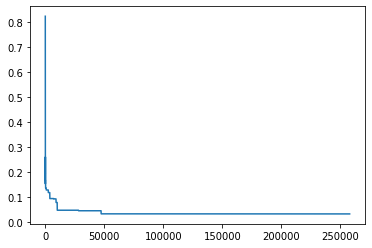

In [175]:
import matplotlib.pyplot as plt

plt.plot(total_errs)

In [176]:
def TCP(y,M, tol=1e-4, max_iter=1000):
    # eliminated = np.array([False]*len(y)).reshape(-1,1)
    # eliminated[np.isnan(y)] = True # Parties not running are eliminated
    yhats = []
    yhat = y.copy()
    yhats.append(yhat.copy())
    yhat[np.isnan(yhat)] = 0
    for _ in range(max_iter):
        argssorted = np.argsort(yhat.reshape(-1))
        argssorted = argssorted[yhat.reshape(-1)[argssorted]>0] # Remove parties that are eliminated
        smallest_remaining_party = argssorted[0] # Index of smallest remaining party
        
        flow = np.zeros_like(yhat)
        flow[smallest_remaining_party] = 1
        flow =  M @ flow

        yhat = yhat + flow*yhat[smallest_remaining_party]
        yhat[smallest_remaining_party,0] = 0

        yhat[yhat<tol] = 0
        yhat = yhat / np.nansum(yhat)
        yhats.append(yhat.copy())

        if sum(yhat!=0)[0] == 2:
            return yhat ,yhats#, eliminated
    print("WARNING: Did not converge")
    return yhat,yhats

In [177]:
first_pref_df = pd.read_csv("HouseFirstPrefsByCandidateByVoteTypeDownload-27966.csv",header=1)
first_pref_df = first_pref_df.apply(partymap,axis=1)
first_pref_df.head()

,StateAb,DivisionID,DivisionNm,CandidateID,Surname,GivenNm,BallotPosition,Elected,HistoricElected,PartyAb,PartyNm,OrdinaryVotes,AbsentVotes,ProvisionalVotes,PrePollVotes,PostalVotes,TotalVotes,Swing
0,ACT,318,Bean,36239,CONWAY,Sean,1,N,N,UAP,United Australia Party,2479,72,7,110,163,2831,0.48
1,ACT,318,Bean,37455,AMBARD,Benjamin,2,N,N,ONP,Pauline Hanson's One Nation,2304,49,5,108,214,2680,2.72
2,ACT,318,Bean,36231,SMITH,David,3,Y,Y,ALP,Australian Labor Party,35883,590,106,915,3566,41060,3.59
3,ACT,318,Bean,32130,CHRISTIE,Jamie,4,N,N,IND,Independent,6953,124,11,176,759,8023,-0.12
4,ACT,318,Bean,36243,SAVERY,Kathryn Jane,5,N,N,GRN,The Greens,12474,396,42,489,1158,14559,1.71


In [178]:
for idx,teal in teal_candidates.iterrows():
    givenNm = teal['GivenNm']
    surname = teal['Surname']
    division = teal['DivisionNm']
    first_pref_df.loc[(first_pref_df[['GivenNm','Surname','DivisionNm']]==[givenNm,surname,division]).all(axis=1),'PartyAb']="TEAL"

In [202]:
divisionName = "Boothby"

d= first_pref_df[first_pref_df["DivisionNm"] == divisionName]
primary = pd.pivot_table(d, columns='PartyAb', values='TotalVotes', aggfunc='sum')
for party in modeled_parties:
    if party not in primary.columns:
        primary[party] = np.nan
primarynumpy = primary.reindex(modeled_parties,axis=1).to_numpy().reshape(-1,1)
primarynumpy = primarynumpy / np.nansum(primarynumpy)
(primary.reindex(modeled_parties,axis=1)/ np.nansum(primary)*100).round(1)

PartyAb,UAP,ONP,ALP,GRN,LNP,IND,TEAL,OTH
TotalVotes,2.1,1.9,30.9,14.5,36.3,5.3,6.3,2.6


In [ ]:
ydist, ys = TCP(primarynumpy,M)
pd.Series(ydist.reshape(-1),index=modeled_parties)

UAP     0.000000
ONP     0.000000
ALP     0.459634
GRN     0.000000
LNP     0.540366
IND     0.000000
TEAL    0.000000
OTH     0.000000
dtype: float64

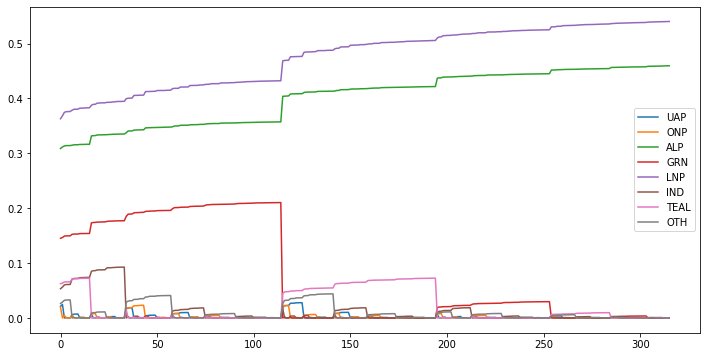

In [204]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
pd.DataFrame(np.concatenate(ys, axis=1).T, columns=modeled_parties).plot(ax=ax)
plt.show()